# Clip: Contrastive Language-Image Pretraining

## Introduction: Why is CLIP Useful

CLIP, represents a significant advancement in the field of artificial intelligence, particularly in the realm of multimodal understanding. It addresses the challenge of understanding and interpreting both text and images in a unified manner. This ability is crucial in various AI applications, including image classification, image retrieval, natural language processing, and more.

One of the key advantages of CLIP is its capacity to learn from large-scale datasets containing both images and their associated textual descriptions. By pretraining on such datasets, CLIP can effectively learn to associate images with their corresponding textual representations. This cross-modal understanding allows CLIP to perform tasks that involve both images and text with remarkable accuracy and efficiency.

In practical terms, CLIP's capabilities have profound implications across numerous domains. It enables more accurate image recognition systems, facilitates natural language-based image searches, and empowers AI systems to better understand and respond to human input in various forms, ranging from textual queries to visual prompts. This versatility makes CLIP a valuable tool for researchers, developers, and organizations seeking to leverage AI technology to solve complex problems and enhance user experiences.

## What did this contribute to the AI community:

CLIP's contributions to the AI community are multifaceted and significant. Firstly, it represents a breakthrough in multimodal learning, demonstrating the effectiveness of cross-modal pretraining in enabling AI models to understand and generate responses across different data modalities. This has inspired further research into multimodal AI systems and spurred advancements in related fields such as computer vision and natural language processing.

Moreover, CLIP has set new benchmarks for performance in various tasks, showcasing the potential of large-scale pretraining and transformer-based architectures in achieving state-of-the-art results. Its ability to generalize across diverse datasets and tasks has led to improvements in tasks such as image classification, object detection, and image-text retrieval.

Furthermore, CLIP's release has sparked widespread interest and collaboration within the AI community. Researchers and practitioners have embraced CLIP as a foundational model for exploring novel applications and advancing the frontiers of AI technology. Its open-source nature has fostered a culture of transparency, reproducibility, and knowledge-sharing, contributing to the democratization of AI research and development.

In summary, CLIP's contributions to the AI community include advancing multimodal learning, setting performance benchmarks, inspiring further research, and fostering collaboration and openness within the field.

## How does CLIP work:

Clip works in 2 main steps:

1. Pretraining with Contrastive Learning: CLIP is pretrained on a massive dataset containing pairs of images and their associated textual descriptions. During pretraining, the model learns to embed both images and text into a shared semantic space where similar concepts are represented by nearby points. This is achieved through a contrastive learning objective, where the model is trained to pull together similar pairs (e.g., an image and its description) while pushing apart dissimilar pairs.

2. Cross-Modal Embeddings: Through pretraining, CLIP learns to generate embeddings (numerical representations) for both images and text such that semantically similar content from different modalities (e.g., an image and its description) have embeddings that are close together in the shared space. This enables CLIP to understand the semantic relationship between images and text, even without explicit training on specific tasks.

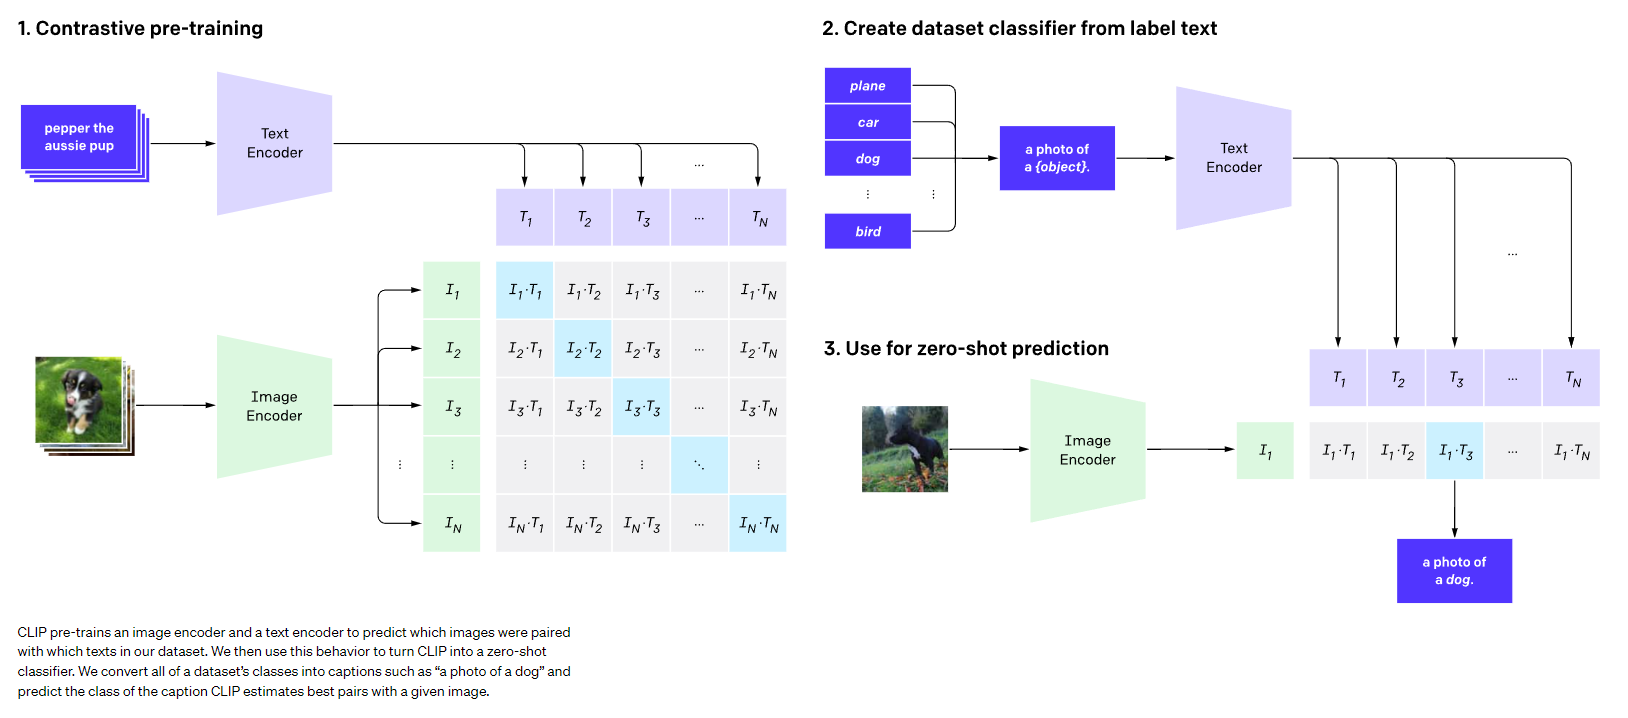


## References:

Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Amodei, D. (2021). Learning transferable visual models from natural language supervision. In Advances in Neural Information Processing Systems (pp. 21407-21420).

OpenAI. "CLIP: Connecting Text and Images". https://openai.com/research/clip

Caron, M., Misra, I., Mairal, J., Goyal, P., Bojanowski, P., & Joulin, A. (2021). Unsupervised learning of visual features by contrasting cluster assignments. arXiv preprint arXiv:2104.13963.

An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale https://arxiv.org/abs/2010.11929

Simple Implementation of OpenAI CLIP model: A Tutorial https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2

In [1]:
import os
import cv2
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import List, Tuple
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, ViTImageProcessor, DistilBertTokenizer

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class CFG:
    # Model Selection
    vision_encoder_model = 'google/vit-base-patch16-224'
    text_encoder_model = "distilbert-base-uncased"

    # Projection Head Parameters
    projection_dim = 768
    dropout = 0.1

    # Data parameters - Image
    image_folder = "datasets/clip_dataset/Images"
    image_size = 224
    image_embedding = 768 # 768 for ViT, 1000 for ResNet

    # Data parameters - Text
    captions_path = "datasets/clip_dataset/captions.txt"
    text_embedding = 768
    max_length = 200

    # Training parameters
    debug = True
    batch_size = 16
    debug_samples = batch_size * 2
    vision_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    epochs = 4
    temperature = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data

In [4]:
# #import requests
# #url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# #image = Image.open(requests.get(url, stream=True).raw) # shape: (640, 480)
# image = Image.open("datasets/clip_dataset/Images/667626_18933d713e.jpg")
# print(f"The image is size {image.size}")

# # Load the image
# #plt.imshow(image)

# feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# model = AutoModel.from_pretrained('google/vit-base-patch16-224')
# #print(model)

# # Pass the image through the feature extractor and the model
# inputs = feature_extractor(images=image, return_tensors="pt")

# print("Keys of inputs:", inputs.keys())

# outputs = model(**inputs)

# # Get the last hidden state from the outputs
# last_hidden_state = outputs.last_hidden_state
# print("Shape of last hidden state:", last_hidden_state.shape)

# # Get the CLIP image embedding
# image_embedding = outputs.pooler_output
# print("Shape of image embedding:", image_embedding.shape)

In [5]:
# text = "a cat sitting on a couch"
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# encoded_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
# model = AutoModel.from_pretrained('distilbert-base-uncased')
# outputs = model(**encoded_text)
# text_embedding = outputs.last_hidden_state[:, 0, :]
# print("Shape of text embedding:", text_embedding.shape)

In [6]:
# !mkdir -p datasets/clip_dataset  # Create the directory if it doesn't exist
# !kaggle datasets download -d adityajn105/flickr8k -p datasets/clip_dataset # Download dataset to datasets/clip
# !unzip pytorch/datasets/flickr8k.zip -d datasets/clip_dataset # Unzip the dataset in datasets/clip

In [7]:
class ClipDataset(Dataset):
    """
    Dataset class for CLIP.

    Args:
        image_folder (Path): Path to the folder containing images.
        image_caption_pair (Tuple[List[str], List[str]]): Tuple of lists containing image filenames and corresponding captions.
        text_tokenizer (DistilBertTokenizer): Pre-trained tokenizer for text.
        image_tokenizer (ViTImageProcessor): Pre-trained image processor.
    """
    def __init__(
            self,
            image_folder: str,
            image_caption_pair: Tuple[List[str], List[str]],
            text_tokenizer: DistilBertTokenizer,
            image_tokenizer: ViTImageProcessor,
            max_length: int = 200,
        ):
        self.image_folder = image_folder
        self.image_filenames = image_caption_pair[0]
        self.text_tokenizer = text_tokenizer
        self.image_tokenizer = image_tokenizer
        self.captions = image_caption_pair[1]
        self.max_length = max_length

    def __getitem__(self, idx):
        """
        Get an item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            dict: Dictionary containing input_ids, attention_mask, image_features, and caption.
        """
        image_path = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(image_path)
        image_features = self.image_tokenizer(images=image, return_tensors="pt")

        encoded_text = self.text_tokenizer(
            self.captions[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoded_text["input_ids"].squeeze(0),
            "attention_mask": encoded_text["attention_mask"].squeeze(0),
            "image_features": image_features.pixel_values.squeeze(0),
            "caption": self.captions[idx]
        }

        return item

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.captions)

In [8]:
def read_captions(path: str) -> Tuple[List[str], List[str]]:
    """
    Read image filenames and corresponding captions from a text file.

    Args:
        path (str): Path to the text file containing image filenames and captions.

    Returns:
        Tuple[List[str], List[str]]: Tuple of lists containing image filenames and captions.
    """
    image_filenames = []
    captions = []

    # Read captions from the text file
    with open(path, "r") as file:
        lines = file.readlines()
        for line in lines:
            # Split each line by the first comma to separate image filename and caption
            parts = line.strip().split(",", maxsplit=1)
            if len(parts) == 2:
                image_filenames.append(parts[0])
                caption = parts[1].replace('"', '')  # Remove quotation marks from caption
                caption = caption.replace(' .', '.')  # Remove space before full stop
                captions.append(caption)

    # Check if the number of image filenames matches the number of captions
    if len(image_filenames) != len(captions):
        raise ValueError("Number of image filenames does not match number of captions.")

    return image_filenames, captions

In [9]:
image_filenames, captions = read_captions("datasets/clip_dataset/captions.txt")
text_tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_encoder_model)
image_tokenizer = ViTImageProcessor.from_pretrained(
    CFG.vision_encoder_model,
    do_normalize=True,
)

if CFG.debug:
    image_caption_pair = (image_filenames[1:CFG.debug_samples+1], captions[1:CFG.debug_samples+1])
else:
    image_caption_pair = (image_filenames[1:], captions[1:])

dataset = ClipDataset(
    image_folder=Path(CFG.image_folder),
    image_caption_pair=image_caption_pair,
    text_tokenizer=text_tokenizer,
    image_tokenizer=image_tokenizer,
)

# Create a DataLoader with batch size 20
batch_size = CFG.batch_size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
(len(dataset), len(dataloader))

(32, 2)

# Building Model

In [11]:
class ProjectionHead(nn.Module):
    """
    Projection head for projecting embeddings into a lower-dimensional space.

    Args:
        embedding_dim (int): Dimensionality of input embeddings.
        projection_dim (int): Dimensionality of projected embeddings (default: CFG.projection_dim).
        dropout (float): Dropout probability (default: CFG.dropout).
    """
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        """
        Forward pass of the projection head.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Projected embeddings.
        """
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [12]:
class VisionEncoder(nn.Module):
    """
    Vision encoder module.

    Args:
        model_name (str): Name or identifier of the pre-trained model (default: CFG.vision_encoder_model).
    """
    def __init__(self, model_name="google/vit-base-patch16-224-in21k", projection_dim=768):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.projection_head = ProjectionHead(
            embedding_dim=self.encoder.config.hidden_size,
            projection_dim=projection_dim
            )
    
    def forward(self, x):
        x = self.encoder(pixel_values=x).pooler_output
        x = self.projection_head(x)
        return x

In [13]:
class TextEncoder(nn.Module):
    """
    Text encoder module.

    Args:
        model_name (str): Name or identifier of the pre-trained model (default: CFG.text_encoder_model).
    """
    def __init__(self, model_name="distilbert-base-uncased", projection_dim=768):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.projection_head = ProjectionHead(
            embedding_dim=self.encoder.config.hidden_size,
            projection_dim=projection_dim
            )
    
    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the text encoder.

        Args:
            **kwargs: Keyword arguments to be passed to the encoder.

        Returns:
            torch.Tensor: Encoded text embeddings.
        """
        outputs  = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
            )
        token_embeddings = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]
        # Apply mean pooling to get sentence-level embeddings
        # Mask out padding tokens before applying pooling
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        masked_token_embeddings = token_embeddings * mask
        sum_token_embeddings = torch.sum(masked_token_embeddings, dim=1)  # Sum along the sequence length
        # Divide by the number of non-padding tokens
        mean_token_embeddings = sum_token_embeddings / torch.sum(attention_mask, dim=1, keepdim=True) # Shape: [batch_size, hidden_size]
        # Project the sentence-level embeddings
        projected_embeddings = self.projection_head(mean_token_embeddings)
        
        return projected_embeddings

# Loss Function

1. Contrastive Loss:
This loss function encourages the model to learn embeddings that are close together for positive (similar) pairs and far apart for negative (dissimilar) pairs.
Typically, it's computed by comparing the cosine similarity between pairs of embeddings to a set of binary labels (1 for positive pairs, 0 for negative pairs).
The loss is commonly computed using a margin-based formulation, where a margin is enforced between positive and negative pairs.
InfoNCE (Information Noise Contrastive Estimation):

2. InfoNCE is a specific form of contrastive loss used in contrastive learning tasks.
It's based on the concept of maximizing the mutual information between representations of positive pairs and minimizing it for negative pairs.
In InfoNCE, the negative log likelihood of the cosine similarity between normalized embeddings is computed, adjusted by a softmax function.
This loss is often used in scenarios where the representations need to capture the most information about the input data.
NT-XentLoss (Normalized Temperature-scaled Cross-entropy loss):

3. NT-XentLoss is another variation of contrastive loss, often used in contrastive learning tasks.
Similar to InfoNCE, it's based on cross-entropy loss but incorporates a temperature scaling factor to control the sharpness of the probability distribution.
NT-XentLoss typically involves computing the cosine similarity between embeddings, scaling them by a temperature parameter, and then applying a softmax function followed by cross-entropy loss.
This loss function is popular because it provides a smooth approximation to InfoNCE and is computationally efficient.

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, text_embeddings, image_embeddings):
        # Normalize embeddings
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

        # Calculate cosine similarity between normalized embeddings
        similarity = torch.matmul(text_embeddings, image_embeddings.t()) / self.temperature

        # Construct labels (1 for positive pairs, 0 for negative pairs)
        labels = torch.arange(text_embeddings.size(0)).to(text_embeddings.device)

        # Compute contrastive loss
        loss = F.cross_entropy(similarity, labels)

        return loss

In [15]:
class NTXentLoss(nn.Module):
    """
    Contrastive loss function based on normalized temperature-scaled cross-entropy (NT-Xent) loss.

    NT-Xent loss is commonly used in contrastive learning to train models for tasks such as 
    image-text retrieval, where the goal is to maximize agreement between embeddings of 
    corresponding pairs and minimize agreement between embeddings of non-corresponding pairs.

    NT-Xent loss is calculated as the mean of the negative log likelihood of the cosine similarity 
    between normalized embeddings of text and images. Higher values indicate lower similarity between 
    corresponding pairs and vice versa.

    Args:
        temperature (float, optional): Scaling factor for cosine similarity (default: 1.0).
    """
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature

    def forward(self, text_embeddings, image_embeddings):
        """
        Forward pass of the NT-Xent loss function.

        Args:
            text_embeddings (torch.Tensor): Embeddings from text encoder.
            image_embeddings (torch.Tensor): Embeddings from vision encoder.

        Returns:
            torch.Tensor: NT-Xent loss value.
        """
        # Normalize embeddings
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

        # Calculate cosine similarity between normalized embeddings
        similarity = torch.matmul(text_embeddings, image_embeddings.t()) / self.temperature

        # Generate positive samples
        batch_size = similarity.size(0)
        labels = torch.arange(batch_size).to(similarity.device)

        # Calculate similarity scores for each sample with itself (positive samples)
        positives = torch.diag(similarity)

        # Compute logits
        logits = torch.cat([positives.view(batch_size, 1), similarity], dim=1)

        # Scale logits for stability
        logits /= self.temperature

        # Compute cross-entropy loss with log-sum-exp for numerical stability
        loss = -torch.mean(torch.log(torch.exp(logits) / torch.sum(torch.exp(logits), dim=1, keepdim=True)))

        return loss

In [16]:
class InfoNCELoss(nn.Module):
    """
    Contrastive loss function based on InfoNCE (Information Noise Contrastive Estimation) loss.

    InfoNCE loss is commonly used in contrastive learning to train models for tasks such as 
    image-text retrieval, where the goal is to maximize agreement between embeddings of 
    corresponding pairs and minimize agreement between embeddings of non-corresponding pairs.

    InfoNCE loss is calculated as the negative log likelihood of the cosine similarity 
    between normalized embeddings of text and images, adjusted by a softmax function.
    Higher values indicate lower similarity between corresponding pairs and vice versa.

    Args:
        temperature (float, optional): Scaling factor for cosine similarity (default: 1.0).
    """
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature

    def forward(self, text_embeddings, image_embeddings):
        """
        Forward pass of the InfoNCE loss function.

        Args:
            text_embeddings (torch.Tensor): Embeddings from text encoder.
            image_embeddings (torch.Tensor): Embeddings from vision encoder.

        Returns:
            torch.Tensor: InfoNCE loss value.
        """
        # Normalize embeddings
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

        # Calculate cosine similarity between normalized embeddings
        similarity = torch.matmul(text_embeddings, image_embeddings.t()) / self.temperature

        # Apply softmax to obtain normalized probabilities
        probabilities = F.softmax(similarity, dim=1)

        # Construct labels for the loss
        batch_size = similarity.size(0)
        labels = torch.arange(batch_size).to(text_embeddings.device)

        # Compute InfoNCE loss
        loss = F.nll_loss(torch.log(probabilities), labels)

        return loss

# Train

In [17]:
num_epochs = CFG.epochs
device = CFG.device
vision_encoder_lr = CFG.vision_encoder_lr
text_encoder_lr = CFG.text_encoder_lr
weight_decay = CFG.weight_decay
patience = CFG.patience

text_model = TextEncoder(model_name=CFG.text_encoder_model).to(device)
vision_model = VisionEncoder(model_name=CFG.vision_encoder_model).to(device)
criterion = NTXentLoss()

optimizer_text = Adam(text_model.parameters(), lr=text_encoder_lr, weight_decay=weight_decay)
optimizer_vision = Adam(vision_model.parameters(), lr=vision_encoder_lr, weight_decay=weight_decay)
scheduler_text = CosineAnnealingLR(optimizer_text, T_max=num_epochs)
scheduler_vision = CosineAnnealingLR(optimizer_vision, T_max=num_epochs)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Placeholder for early stopping
best_loss = float('inf')
patience_count = 0

# Training loop
loss_history = []
for epoch in range(num_epochs):
    text_model.train()
    vision_model.train()
    total_batch_loss = 0.0
    for batch in dataloader:
        # Move batch to device
        # Shape [batch_size, seq_len]
        text_inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            }
        # Move image features to device
        # Shape [batch_size, channels, height, width]
        image_inputs = batch["image_features"].to(device) #

        # set optimizer gradients to zero
        optimizer_text.zero_grad()
        optimizer_vision.zero_grad()
        
        # Forward pass
        # [batch_size, hidden_size] -> [batch_size, projection_dim]
        text_embeddings = text_model(
            input_ids=text_inputs["input_ids"],
            attention_mask=text_inputs["attention_mask"],
            )
        # [batch_size, channels, height, width] -> [batch_size, projection_dim]
        image_embeddings = vision_model(
            image_inputs,
            )

        # Calculate loss
        loss = criterion(text_embeddings, image_embeddings)
        total_batch_loss += loss.item()

        # Backpropagation for text encoder
        loss.backward()
        optimizer_text.step()
        optimizer_vision.step()

    # Save the average loss for the epoch
    avg_epoch_loss = total_batch_loss/len(dataloader)
    loss_history.append(avg_epoch_loss)

    # Learning rate scheduling
    scheduler_text.step()
    scheduler_vision.step()

    # Early stopping
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_count = 0
    else:
        patience_count += 1
        if patience_count >= patience:
            print("Early stopping triggered.")
            break

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss}")

Epoch [1/4], Loss: 2.8337700366973877
Epoch [2/4], Loss: 2.833658456802368
Epoch [3/4], Loss: 2.833337426185608
Early stopping triggered.


# Inference

In [19]:
def clip_inference(text_model, vision_model, dataloader, device):
    """
    Perform inference using the trained text and vision models.

    Args:
        text_model (nn.Module): Trained text model.
        vision_model (nn.Module): Trained vision model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to perform inference on.

    Returns:
        tuple: Tuple containing text embeddings and image embeddings.
    """
    # Set models to evaluation mode
    text_model.to(device).eval()
    vision_model.to(device).eval()

    # Placeholder for storing embeddings
    text_embeddings_list = []
    image_embeddings_list = []

    # Iterate over the dataset for inference
    for batch in dataloader:
        # Move batch to device
        text_inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
        }
        image_inputs = batch["image_features"].to(device)

        # Forward pass for text encoder
        with torch.no_grad():
            text_embeddings = text_model(
                input_ids=text_inputs["input_ids"],
                attention_mask=text_inputs["attention_mask"],
            )
        text_embeddings_list.append(text_embeddings)

        # Forward pass for vision encoder
        with torch.no_grad():
            image_embeddings = vision_model(image_inputs)
        image_embeddings_list.append(image_embeddings)

    # Concatenate embeddings from all batches
    text_embeddings_all = torch.cat(text_embeddings_list, dim=0)
    image_embeddings_all = torch.cat(image_embeddings_list, dim=0)

    return text_embeddings_all, image_embeddings_all

In [20]:
# Sample usage
text_embeddings, image_embeddings = clip_inference(text_model, vision_model, dataloader, device)
print("Shape of text embeddings:", text_embeddings.shape)
print("Shape of image embeddings:", image_embeddings.shape)

Shape of text embeddings: torch.Size([32, 768])
Shape of image embeddings: torch.Size([32, 768])
